In [1]:
#@title Load the imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

print("Imported the modules.")

2023-06-29 19:38:33.355103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 19:38:34.504732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Imported the modules.


In [2]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

In [3]:
# Keras Input tensors of float values.
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude')
}

In [4]:
#@title Define functions to create and train a model, and a plotting function
def create_model(my_inputs, my_outputs, my_learning_rate):

  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                     verbose=0
                     )

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the mean absolute error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()  

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


2023-06-29 19:38:43.728568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 19:38:43.892806: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/mount/Project/Project Files/PythonEnvs/DataSciEnv2/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latitude (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 longitude (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['latitude[0][0]',               
                                                                  'longitude[0][0]']              
                                                                                                  
 dense_layer (Dense)            (None, 1)            3           ['concatenate[0][0]']        

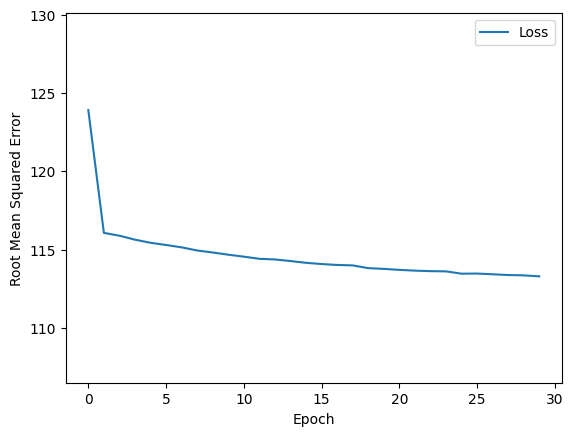


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 12220.2441 - root_mean_squared_error: 110.5452


/mount/Project/Project Files/PythonEnvs/DataSciEnv2/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[12220.244140625, 110.54521179199219]

In [5]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# The two Input layers are concatenated so they can be passed as a single
# tensor to a Dense layer.
preprocessing_layer = tf.keras.layers.Concatenate()(inputs.values())

dense_output = layers.Dense(
    units=1,
    input_shape=(1,),
    name='dense_layer')(preprocessing_layer)

outputs = {
  'dense_output': dense_output
}

# Create and compile the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# To view a PNG of this model's layers, uncomment the call to
# `tf.keras.utils.plot_model` below. After running this code cell, click
# the file folder on the left, then the `my_model.png` file.
# tf.keras.utils.plot_model(my_model, "my_model.png", show_shapes=True)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [6]:
resolution_in_degrees = 1.0

# Create a list of numbers representing the bucket boundaries for latitude.
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])), 
                                     resolution_in_degrees))
print("latitude boundaries: " + str(latitude_boundaries))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Number of categories is the length of latitude_boundaries plus one.
latitude = tf.keras.layers.CategoryEncoding(
    num_tokens=len(latitude_boundaries) + 1,
    output_mode='one_hot',
    name='category_encoding_latitude')(latitude)

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])), 
                                      resolution_in_degrees))

print("longitude boundaries: " + str(longitude_boundaries))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# Number of categories is the length of longitude_boundaries plus one.
longitude = tf.keras.layers.CategoryEncoding(
    num_tokens=len(longitude_boundaries) + 1,
    output_mode='one_hot',
    name='category_encoding_longitude')(longitude)

# Concatenate latitude and longitude into a single tensor as input for the Dense layer.
concatenate_layer = tf.keras.layers.Concatenate()([latitude, longitude])

# concatenated_features = tf.keras.layers.Concatenate(name='concatenated_features')([latitude, longitude])


dense_output = layers.Dense(
    units=1, input_shape=(2,), name='dense_layer')(concatenate_layer)

# Define an output dictionary we'll send to the model constructor.
outputs = {
  'dense_output': dense_output
}

latitude boundaries: [32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
longitude boundaries: [-124.0, -123.0, -122.0, -121.0, -120.0, -119.0, -118.0, -117.0, -116.0, -115.0]


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latitude (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 longitude (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 discretization_latitude (Discr  (None, 1)           0           ['latitude[0][0]']               
 etization)                                                                                       
                                                                                                  
 discretization_longitude (Disc  (None, 1)           0           ['longitude[0][0]']        

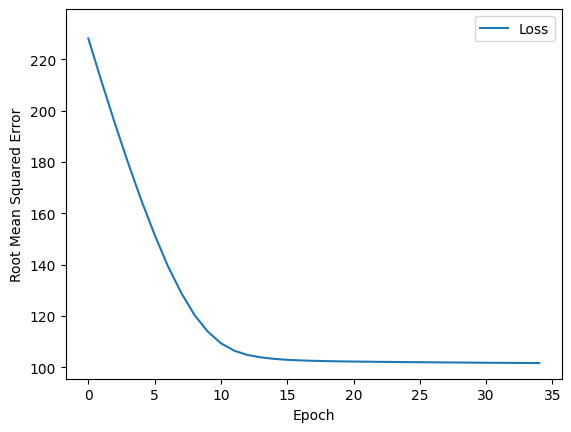


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 1ms/step - loss: 10201.4795 - root_mean_squared_error: 101.0024


/mount/Project/Project Files/PythonEnvs/DataSciEnv2/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[10201.4794921875, 101.00238037109375]

In [7]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [8]:
# !pip install --upgrade tensorflow

In [9]:
resolution_in_degrees = 1.0

# Create a list of numbers representing the bucket boundaries for latitude.
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])), 
                                     resolution_in_degrees))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])), 
                                      resolution_in_degrees))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# Cross the latitude and longitude features into a single one-hot vector.
feature_cross = tf.keras.layers.HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boundaries), 
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

dense_output = layers.Dense(units=1, input_shape=(2,), 
                            name='dense_layer')(feature_cross)

# Define an output dictionary we'll send to the model constructor.
outputs = {
  'dense_output': dense_output
}

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latitude (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 longitude (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 discretization_latitude (Discr  (None, 1)           0           ['latitude[0][0]']               
 etization)                                                                                       
                                                                                                  
 discretization_longitude (Disc  (None, 1)           0           ['longitude[0][0]']        

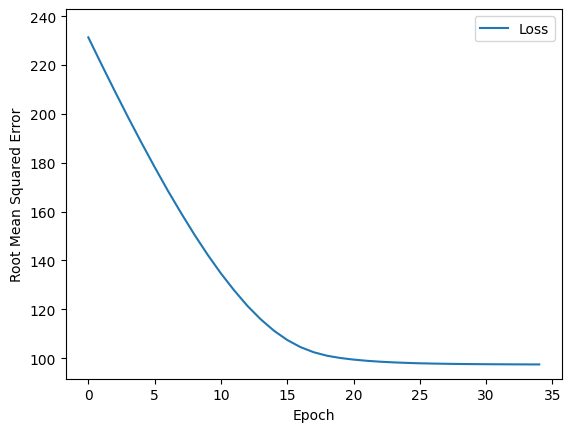


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 9319.4150 - root_mean_squared_error: 96.5371


/mount/Project/Project Files/PythonEnvs/DataSciEnv2/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[9319.4150390625, 96.53711700439453]

In [11]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)